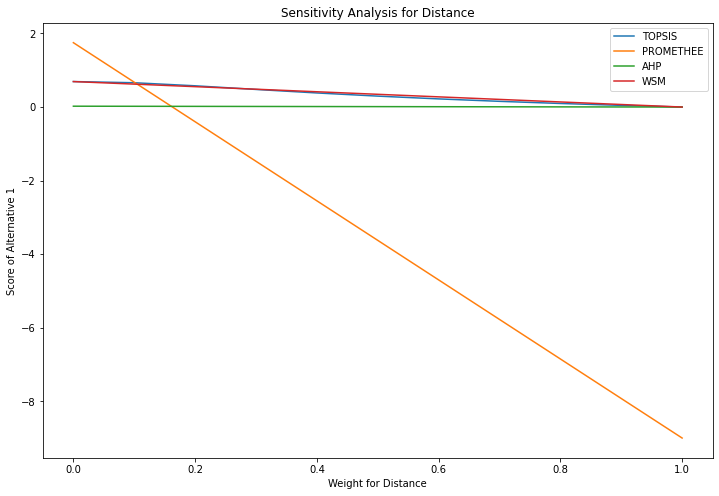

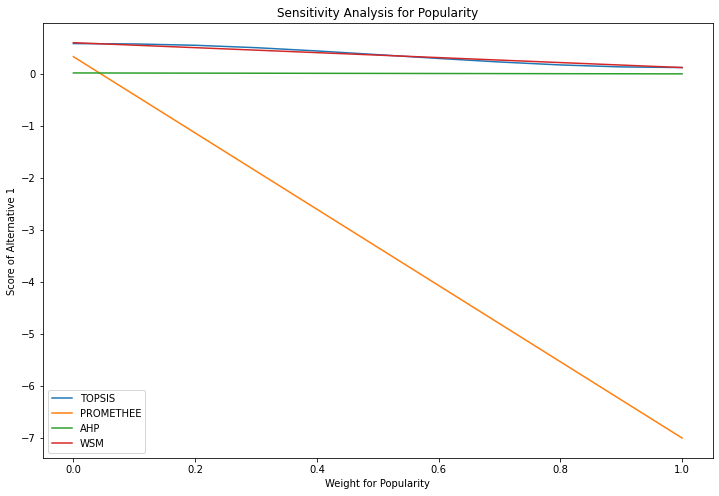

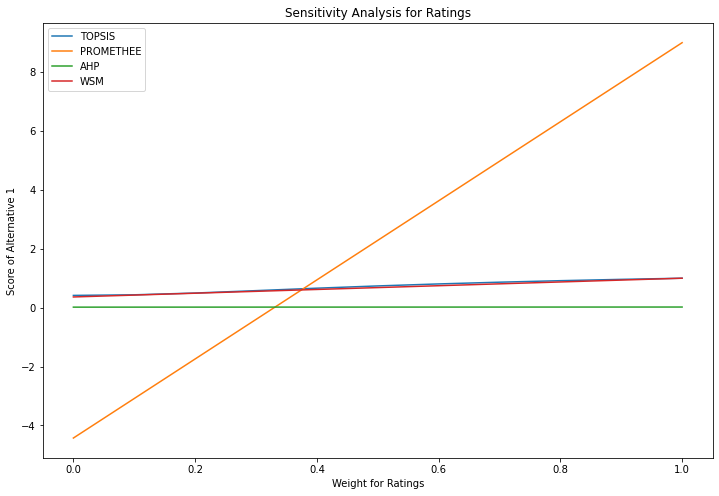

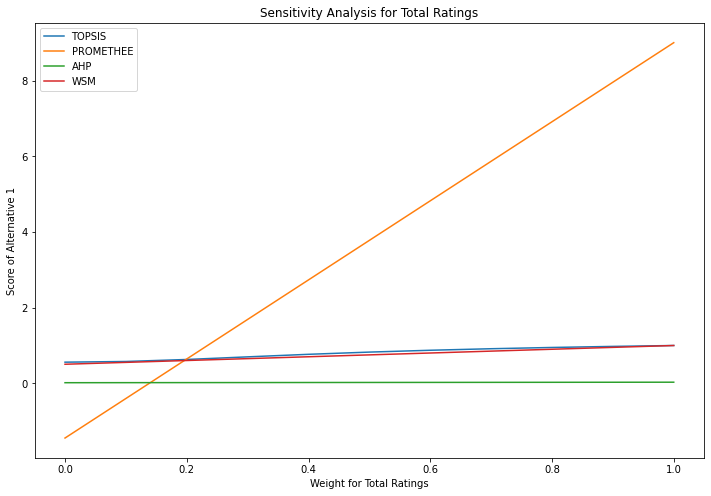

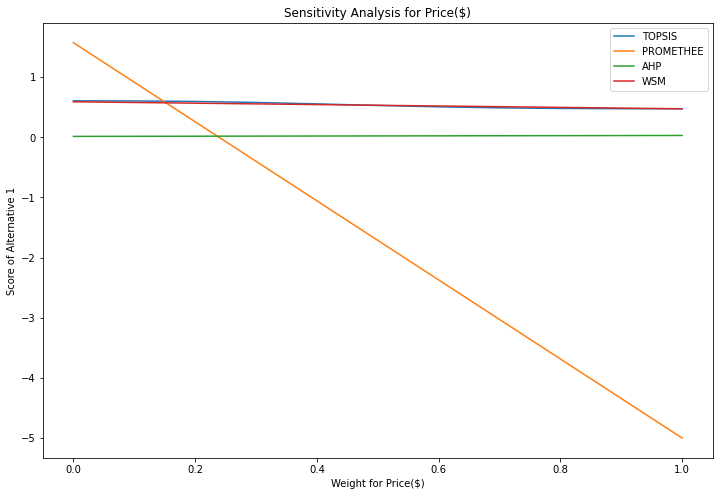

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def normalize(data, criteria):
    for criterion in criteria:
        if criterion == 'Price($)':
            data[criterion] = (data[criterion].max() - data[criterion]) / (data[criterion].max() - data[criterion].min())
        else:
            data[criterion] = (data[criterion] - data[criterion].min()) / (data[criterion].max() - data[criterion].min())
    return data

def topsis(data, weights):
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ['Latitude', 'Longitude', 'Category ID']]
    normalized_matrix = data[numeric_columns] / np.linalg.norm(data[numeric_columns], axis=0)
    weights_list = [weights[col] for col in numeric_columns]
    weighted_normalized_matrix = normalized_matrix * np.array(weights_list)
    ideal_best = np.max(weighted_normalized_matrix, axis=0)
    ideal_worst = np.min(weighted_normalized_matrix, axis=0)
    distance_best = np.linalg.norm(weighted_normalized_matrix - ideal_best, axis=1)
    distance_worst = np.linalg.norm(weighted_normalized_matrix - ideal_worst, axis=1)
    performance_score = distance_worst / (distance_best + distance_worst)
    return performance_score

def promethee(data, weights):
    weighted_sum = np.zeros(len(data))
    for i in range(len(data)):
        for j in range(len(data)):
            if i != j:
                pref_ij = np.sum([int(data.iloc[i][criterion] > data.iloc[j][criterion]) * weights[criterion] for criterion in weights.keys()])
                pref_ji = np.sum([int(data.iloc[j][criterion] > data.iloc[i][criterion]) * weights[criterion] for criterion in weights.keys()])
                weighted_sum[i] += pref_ij - pref_ji
    return weighted_sum

def ahp(data, weights, criteria_comparison):
    weighted_sum = np.zeros(len(data))
    for criterion, weight in weights.items():
        pairwise_comparison_vector = np.array(criteria_comparison[criterion])
        normalized_comparison_vector = pairwise_comparison_vector / np.sum(pairwise_comparison_vector)
        normalized_comparison_vector_extended = np.repeat(normalized_comparison_vector, len(data) // len(normalized_comparison_vector))
        weighted_sum += data[criterion].values * normalized_comparison_vector_extended * weight
    return weighted_sum

def wsm(data, weights):
    weighted_sum = sum(data[c] * weights[c] for c in weights.keys() if c in data.columns)
    return weighted_sum

csv_files = ['POI_FINAL_Museum.csv', 'POI_FINAL_Restaurant.csv', 'POI_FINAL_Travel_Agency.csv']
criteria = ['Distance', 'Popularity', 'Ratings', 'Total Ratings', 'Price($)']
base_weights = {'Distance': 0.2, 'Popularity': 0.1, 'Ratings': 0.3, 'Total Ratings': 0.1, 'Price($)': 0.3}
criteria_comparison = {
    'Distance': [1, 3, 5, 7, 9],
    'Popularity': [1/3, 1, 3, 5, 7],
    'Ratings': [1/5, 1/3, 1, 3, 5],
    'Total Ratings': [1/7, 1/5, 1/3, 1, 3],
    'Price($)': [1/9, 1/7, 1/5, 1/3, 1]
}

data = pd.read_csv(csv_files[0], encoding='latin1')
data = normalize(data, criteria)
alternative_index = 0  # Index of the alternative you want to track

def sensitivity_analysis(data, criteria, base_weights, alternative_index, criteria_comparison):
    for criterion in criteria:
        sensitivity_results = {'Weight for ' + criterion: [], 'TOPSIS': [], 'PROMETHEE': [], 'AHP': [], 'WSM': []}
        for weight in np.linspace(0, 1, 11):
            adjusted_weights = base_weights.copy()
            adjusted_weights[criterion] = weight
            total_other_weights = sum([base_weights[c] for c in criteria if c != criterion])
            for c in criteria:
                if c != criterion:
                    adjusted_weights[c] = base_weights[c] * ((1 - weight) / total_other_weights)

            topsis_scores = topsis(data, adjusted_weights)
            promethee_scores = promethee(data, adjusted_weights)
            ahp_scores = ahp(data, adjusted_weights, criteria_comparison)
            wsm_scores = wsm(data, adjusted_weights)

            sensitivity_results['Weight for ' + criterion].append(weight)
            sensitivity_results['TOPSIS'].append(topsis_scores[alternative_index])
            sensitivity_results['PROMETHEE'].append(promethee_scores[alternative_index])
            sensitivity_results['AHP'].append(ahp_scores[alternative_index])
            sensitivity_results['WSM'].append(wsm_scores[alternative_index])

        sensitivity_df = pd.DataFrame(sensitivity_results)

        plt.figure(figsize=(12, 8))
        plt.plot(sensitivity_df['Weight for ' + criterion], sensitivity_df['TOPSIS'], label='TOPSIS')
        plt.plot(sensitivity_df['Weight for ' + criterion], sensitivity_df['PROMETHEE'], label='PROMETHEE')
        plt.plot(sensitivity_df['Weight for ' + criterion], sensitivity_df['AHP'], label='AHP')
        plt.plot(sensitivity_df['Weight for ' + criterion], sensitivity_df['WSM'], label='WSM')
        plt.xlabel(f'Weight for {criterion}')
        plt.ylabel(f'Score of Alternative {alternative_index + 1}')
        plt.title(f'Sensitivity Analysis for {criterion}')
        plt.legend()
        plt.show()

sensitivity_analysis(data, criteria, base_weights, alternative_index, criteria_comparison)


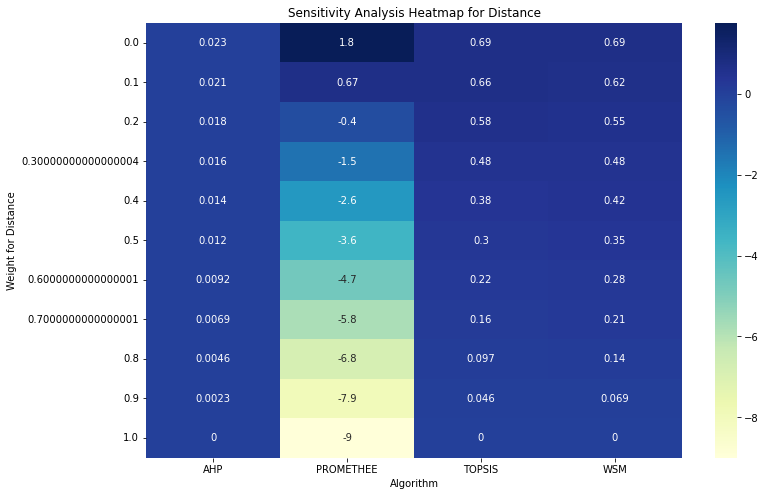

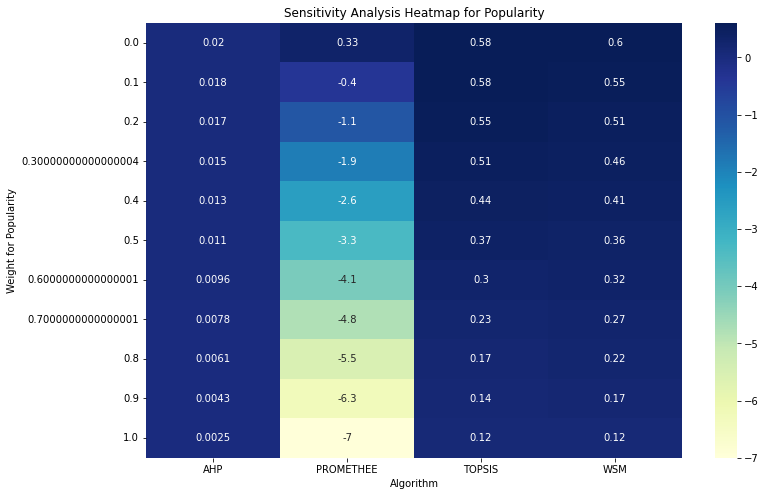

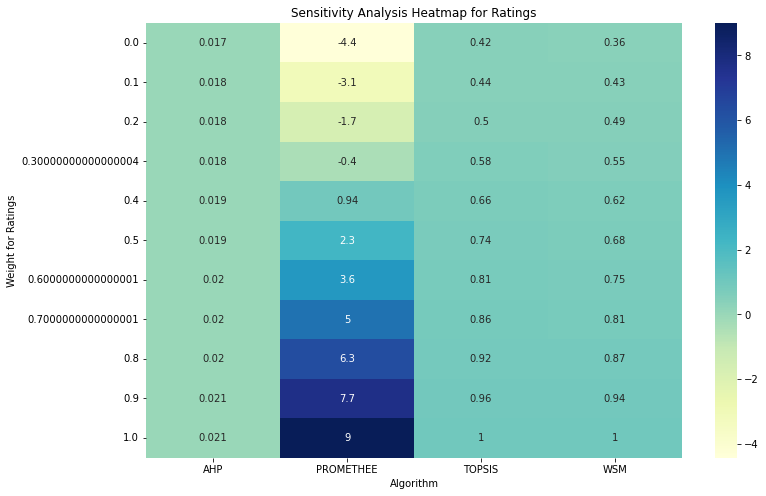

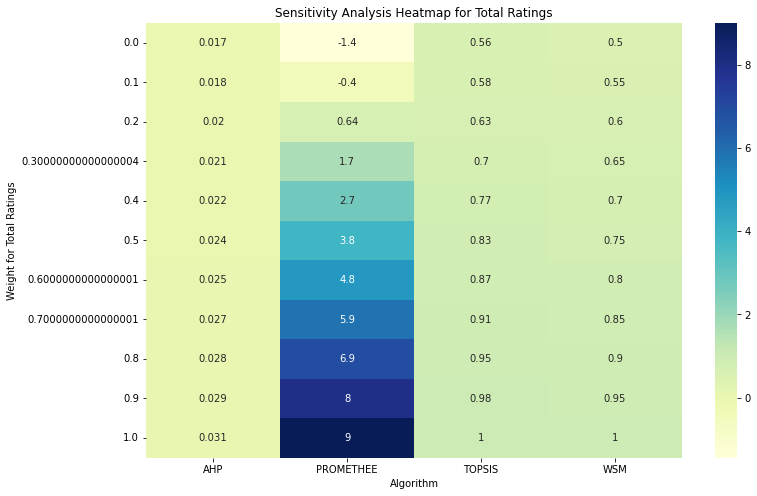

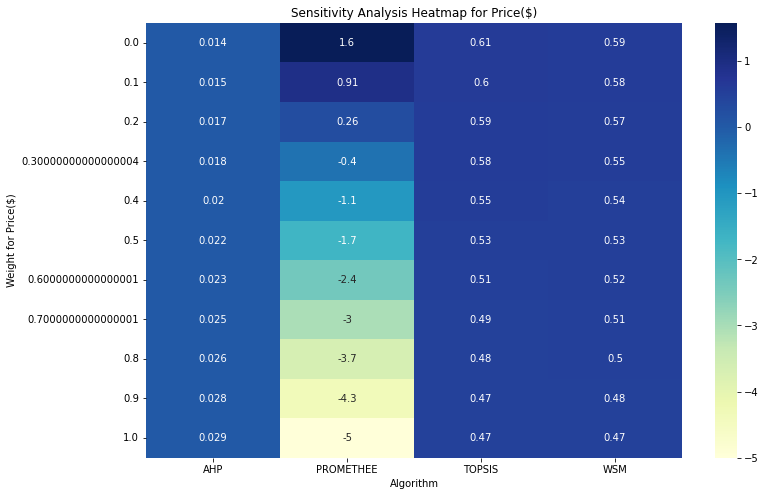

In [7]:
import seaborn as sns

def sensitivity_analysis(data, criteria, base_weights, alternative_index, criteria_comparison):
    for criterion in criteria:
        sensitivity_results = {'Weight for ' + criterion: [], 'Algorithm': [], 'Score': []}
        for weight in np.linspace(0, 1, 11):
            adjusted_weights = base_weights.copy()
            adjusted_weights[criterion] = weight
            total_other_weights = sum([base_weights[c] for c in criteria if c != criterion])
            for c in criteria:
                if c != criterion:
                    adjusted_weights[c] = base_weights[c] * ((1 - weight) / total_other_weights)

            topsis_scores = topsis(data, adjusted_weights)
            promethee_scores = promethee(data, adjusted_weights)
            ahp_scores = ahp(data, adjusted_weights, criteria_comparison)
            wsm_scores = wsm(data, adjusted_weights)

            sensitivity_results['Weight for ' + criterion].extend([weight]*4)
            sensitivity_results['Algorithm'].extend(['TOPSIS', 'PROMETHEE', 'AHP', 'WSM'])
            sensitivity_results['Score'].extend([topsis_scores[alternative_index], promethee_scores[alternative_index],
                                                 ahp_scores[alternative_index], wsm_scores[alternative_index]])

        sensitivity_df = pd.DataFrame(sensitivity_results)

        pivot_df = sensitivity_df.pivot('Weight for ' + criterion, 'Algorithm', 'Score')
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap='YlGnBu')
        plt.xlabel('Algorithm')
        plt.ylabel(f'Weight for {criterion}')
        plt.title(f'Sensitivity Analysis Heatmap for {criterion}')
        plt.show()

sensitivity_analysis(data, criteria, base_weights, alternative_index, criteria_comparison)
